In [127]:
import sys 
import typing as t
from collections import namedtuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from skimage.feature import greycomatrix, greycoprops

# add src to path
sys.path.append('../..')
from utils.db_helper import get_image_data
from utils.color_space_operations import all_colorspaces_from_rgb
# from utils.color_space_operations import all_colorspaces_from_rgb

In [ ]:
SOURCE_DIR_STYLE = R"F:\master-thesis-databases\classification_db\fake"
SOURCE_DIR_FFHQ = R"F:\master-thesis-databases\classification_db\real"
datasets = {
    'real': np_comatrix_ffhq,
    'fake': np_comatrix_style
}

In [ ]:
GRAYSCALE=False
base_save_path = os.path.join("..", "..", "..", "exp", "Comatrix")
DISTANCES = [1,2]
ANGLES = [0, np.pi/4, np.pi/2, 3*np.pi/4]


In [ ]:
def comatrix_from_image(np_img: np.ndarray, distances: t.List[int], angles: t.List[float])-> np.ndarray:
    if len(np_img.shape) == 3:
         np_comatrix = np.empty((256,256,np_img.shape[-1],len(distances),len(angles)))
         for i in range(np_img.shape[-1]):
            np_comatrix[:,:,i] = greycomatrix(np_img[:,:,i], distances, angles)
    else:
        raise ValueError('Image array must have 3 dimensions')
    return np_comatrix

In [ ]:
def comatrix_from_dataset(src_path: str, distances: t.List[int], angles: t.List[float], grayscale=False)-> np.ndarray:
    print("Loading dataset...")
    dataset_gen = get_image_data(src_path, type='int', grayscale=grayscale, max_number_of_images=1000)
    final_type = np.float64
    print("Processing database...")
    np_comatrix_dataset = np.zeros((256,256,9,len(distances),len(angles)), 
                                   dtype=final_type)
    number_of_images = 0
    for np_image in dataset_gen:
        np_image = all_colorspaces_from_rgb(np_image, type='int')
        np_tmp_comatrix = comatrix_from_image(np_image, distances, angles)
        np_comatrix_dataset += np_tmp_comatrix
        number_of_images +=1
        if number_of_images % 100 == 0:
            print(f"Image number: {number_of_images}")
        elif np_comatrix_dataset.max() > 0.95*np.finfo(final_type).max:
            raise ValueError("Dataset to large, datatype overflow")
            break
    print (f"{number_of_images} processed from path: {src_path}")
    return np_comatrix_dataset / number_of_images

In [ ]:
# def display_comatrix(np_comatrix_dataset: np.ndarray):
np_comatrix_ffhq = comatrix_from_dataset(SOURCE_DIR_FFHQ, DISTANCES, ANGLES, grayscale=False)
np_comatrix_style = comatrix_from_dataset(SOURCE_DIR_STYLE, DISTANCES, ANGLES, grayscale=GRAYSCALE)

## Comatrix

In [ ]:
if GRAYSCALE:
    color_channels = {
    "0": 'Gray',
    }
else:
    color_channels = {
        "0": 'R',
        "1": 'G',
        '2': 'B',
        '3': 'H',
        '4': 'S',
        '5': 'V',
        '6': 'Y',
        '7': 'Cb',
        '8': 'Cr'
    }

In [ ]:
i=0
for distance in DISTANCES:
    j=0
    for angle in ANGLES:
        fig, axs = plt.subplots(nrows=int(len(datasets)*len(color_channels)/3), ncols=3, figsize=(15,15))
        fig.suptitle(f'Comatrixes for distance: {distance} and angle: {angle} rads')
        plt.subplots_adjust(hspace=0.5)
        row=0
        dataset_nr=0
        for name, dataset in datasets.items():
            # if len(color_channels) > 1:
            for col in range(len(color_channels)):
                if col%3 == 0 and col>0:
                    row+=1
                axs[row+dataset_nr,col%3].imshow(dataset[:,:,col,i,j])
                axs[row+dataset_nr,col%3].set_title(f"{name}_{color_channels[str(col)]}")
            dataset_nr+=1
            
        #saving image
        #directory = 'Grayscale' if GRAYSCALE else 'Colors'
        filename = f"{distance}_{angle}.png"
        save_path = os.path.join(base_save_path, filename)
        plt.show()
        #fig.savefig(save_path)
        j+=1
    i+=1

# Greycoprops

## Based on avg comatrix from datasets

In [ ]:
save_path = os.path.join(base_save_path, "greycoprops.csv")
greycoprops_properties = ("contrast", "dissimilarity", "homogeneity", "ASM", "energy", "correlation")
df = pd.DataFrame(columns=['Property', 'Color', 'Angle', 'Distance', 'Value_fake', 'Value_real', 'Diff_Value'])

In [ ]:
index=0
for prop in greycoprops_properties:
    print(f"Result for {prop}")
    for i in range(len(color_channels)):
        result_real = greycoprops(np_comatrix_ffhq[:,:,i,:,:], prop=prop)
        result_fake = greycoprops(np_comatrix_style[:,:,i,:,:], prop=prop)
        diff = np.abs((result_real-result_fake)/(result_real+result_fake))
        dist, angle = np.unravel_index(np.argmax(diff), diff.shape)
        print(f"Color: {color_channels[str(i)]}, Distance: {DISTANCES[dist]}, Angle: {ANGLES[angle]}, Value: {np.max(diff)}")
        df.loc[index] = [prop, color_channels[str(i)], ANGLES[angle], DISTANCES[dist], result_real[dist, angle], result_fake[dist, angle], np.max(diff)]
        index+=1

In [129]:
df = df.sort_values('Diff_Value', ascending=False)
#df.to_csv(save_path)
df[:4]

,Property,Color,Angle,Distance,Value_fake,Value_real,Diff_Value
31,ASM,S,0.000000,2,0.000501,0.000228,0.374756
7,contrast,Cb,1.570796,2,8.340733,4.708125,0.278385
8,contrast,Cr,1.570796,2,11.247328,6.666144,0.255740
4,contrast,S,1.570796,1,237.847547,142.915376,0.249321


In [95]:
def greycoprops_from_image(np_img: np.ndarray, distances: t.List[int], angles: t.List[float], prop: str):
    from skimage.feature import greycoprops
    np_comatrix = comatrix_from_image(np_img, distances, angles)
    if len(np_img.shape) == 3:
        np_result = np.empty((np_img.shape[-1], len(distances), len(angles)))
        for i in range(np_img.shape[-1]):
            np_result[i] = greycoprops(np_comatrix[:,:,i,:,:], prop=prop)
    else:
        raise ValueError ("Image shape not supported")

    return np_result

## Compare values of greycoprops for single images

In [130]:
df

,Property,Color,Angle,Distance,Value_fake,Value_real,Diff_Value
31,ASM,S,0.000000,2,0.000501,0.000228,0.374756
7,contrast,Cb,1.570796,2,8.340733,4.708125,0.278385
8,contrast,Cr,1.570796,2,11.247328,6.666144,0.255740
4,contrast,S,1.570796,1,237.847547,142.915376,0.249321


In [166]:
angle = [1.570796]
distance = [1]
color = 4 
prop = 'contrast'
number_of_images = 100

In [167]:
ffhq_gen = get_image_data(SOURCE_DIR_FFHQ, type='int', grayscale=False, max_number_of_images=number_of_images)
style_gen = get_image_data(SOURCE_DIR_STYLE, type='int', grayscale=False, max_number_of_images=number_of_images)

In [168]:
results1 = []
for np_img in ffhq_gen:
    np_all_img = all_colorspaces_from_rgb(np_img, type='int')
    greycoprop = greycoprops_from_image(np_all_img, distance, angle, prop=prop)[color,0,0]
    results1.append(greycoprop)

len: 100


In [169]:
results2 = []
for np_img in style_gen:
    np_all_img = all_colorspaces_from_rgb(np_img, type='int')
    greycoprop = greycoprops_from_image(np_all_img, distance, angle, prop=prop)[color,0,0]
    results2.append(greycoprop)

len: 100


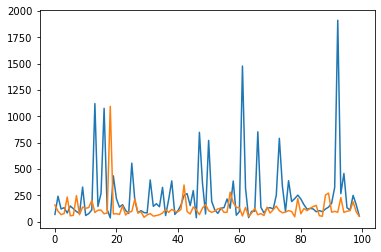

In [171]:
plt.plot(range(len(results1)), results1)
plt.plot(range(len(results2)), results2)